# Desafio

En esta sesión trabajaremos con una base de datos sobre clientes morosos de un banco.

Dentro de ésta se registran las siguientes observaciones:

- `default`: Variable binaria. Registra si el cliente entró en morosidad o no.
- `income`: Ingreso promedio declarado por el cliente.
- `balance`: Total de saldo en la cuenta de crédito.
- `student`: Variable binaria. Registra si el cliente es estudiante o no.

## Parte 1: Preparación del ambiente de trabajo

- Importe los módulos básicos para el análisis de datos
- Importe `seaborn`.
- Importe `statsmodels`.
- Importe `LogisticRegression`, `train_test_split`, `StandardScaler`, `classification_report` y `roc_curve` de `sklearn`.

## Parte 2: Análisis exploratorio

- Explore las principales relaciones entre las variables. Utilizando los métodos `boxplot` y `lmplot` de `seaborn` implemente los siguientes gráficos.
    - Un boxplot del balance total de las cuentas, segmentado por el status de estudiante.
    - Un boxplot del ingreso total de cada cliente, segmentado por el status de estudiante.
    - Un boxplot del balance total de las cuentas, segmentado por el status de default.
    - Un boxplot del ingreso total de cada cliente, segmentado por el status de default.
    - Un diagrama de dispersión entre balance e income, segmentado por el status de estudiante.
    - Un diagrama de dispersión entre balance e income, segmentado por el status de default.
- Comente brevemente sobre los principales patrones de comportamiento.
- **tip**: Puede utilizar el argumento `hue` en `lmplot` para identificar las observaciones por status.

## Parte 3: Refactorización del modelo

- Recodifique las variables `student` y `default` para que adquieran atributos numéricos.
- Implemente algún método de resampling (balanceo) en la clase LogisticRegression . Comente sobre los resultados obtenidos.
- A partir de este modelo, depúrelo y mantenga las principales características. Ejecute de nuevo el modelo y comente brevemente sobre el comportamiento de los
atributos.

## Parte 4: Entrenar

A partir del modelo depurado, genere un modelo predictivo con las siguientes características:
- Estandarice la matriz de atributos.
- Genere subconjuntos de entrenamiento y validación, separando el 33% de la muestra en el conjunto de validación.
- Implemente el modelo sin alterar los hiper parámetros.
- Genere la predicción de las clases y de la probabilidad.
- Reporte las métricas de precisión, recall y f1 para ambas clases.
- Grafique la curva Receiver Operator Characteristic.
- En base a los pasos, comente sobre el desempeño predictivo del modelo.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve
# !pip install imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
import statsmodels
from sklearn.preprocessing import LabelEncoder
import warnings
import os
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)

df = pd.read_csv('default_credit.csv')
df

,index,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879
...,...,...,...,...,...
9995,9996,No,No,711.555020,52992.378914
9996,9997,No,No,757.962918,19660.721768
9997,9998,No,No,845.411989,58636.156984
9998,9999,No,No,1569.009053,36669.112365


In [43]:
df['default'] = df['default'].astype('category');
df['student'] = df['student'].astype('category');
df.info();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   index    10000 non-null  int64   
 1   default  10000 non-null  category
 2   student  10000 non-null  category
 3   balance  10000 non-null  float64 
 4   income   10000 non-null  float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 254.3 KB


**Boxplot del balance total de las cuentas, segmentado por el status de estudiante.**

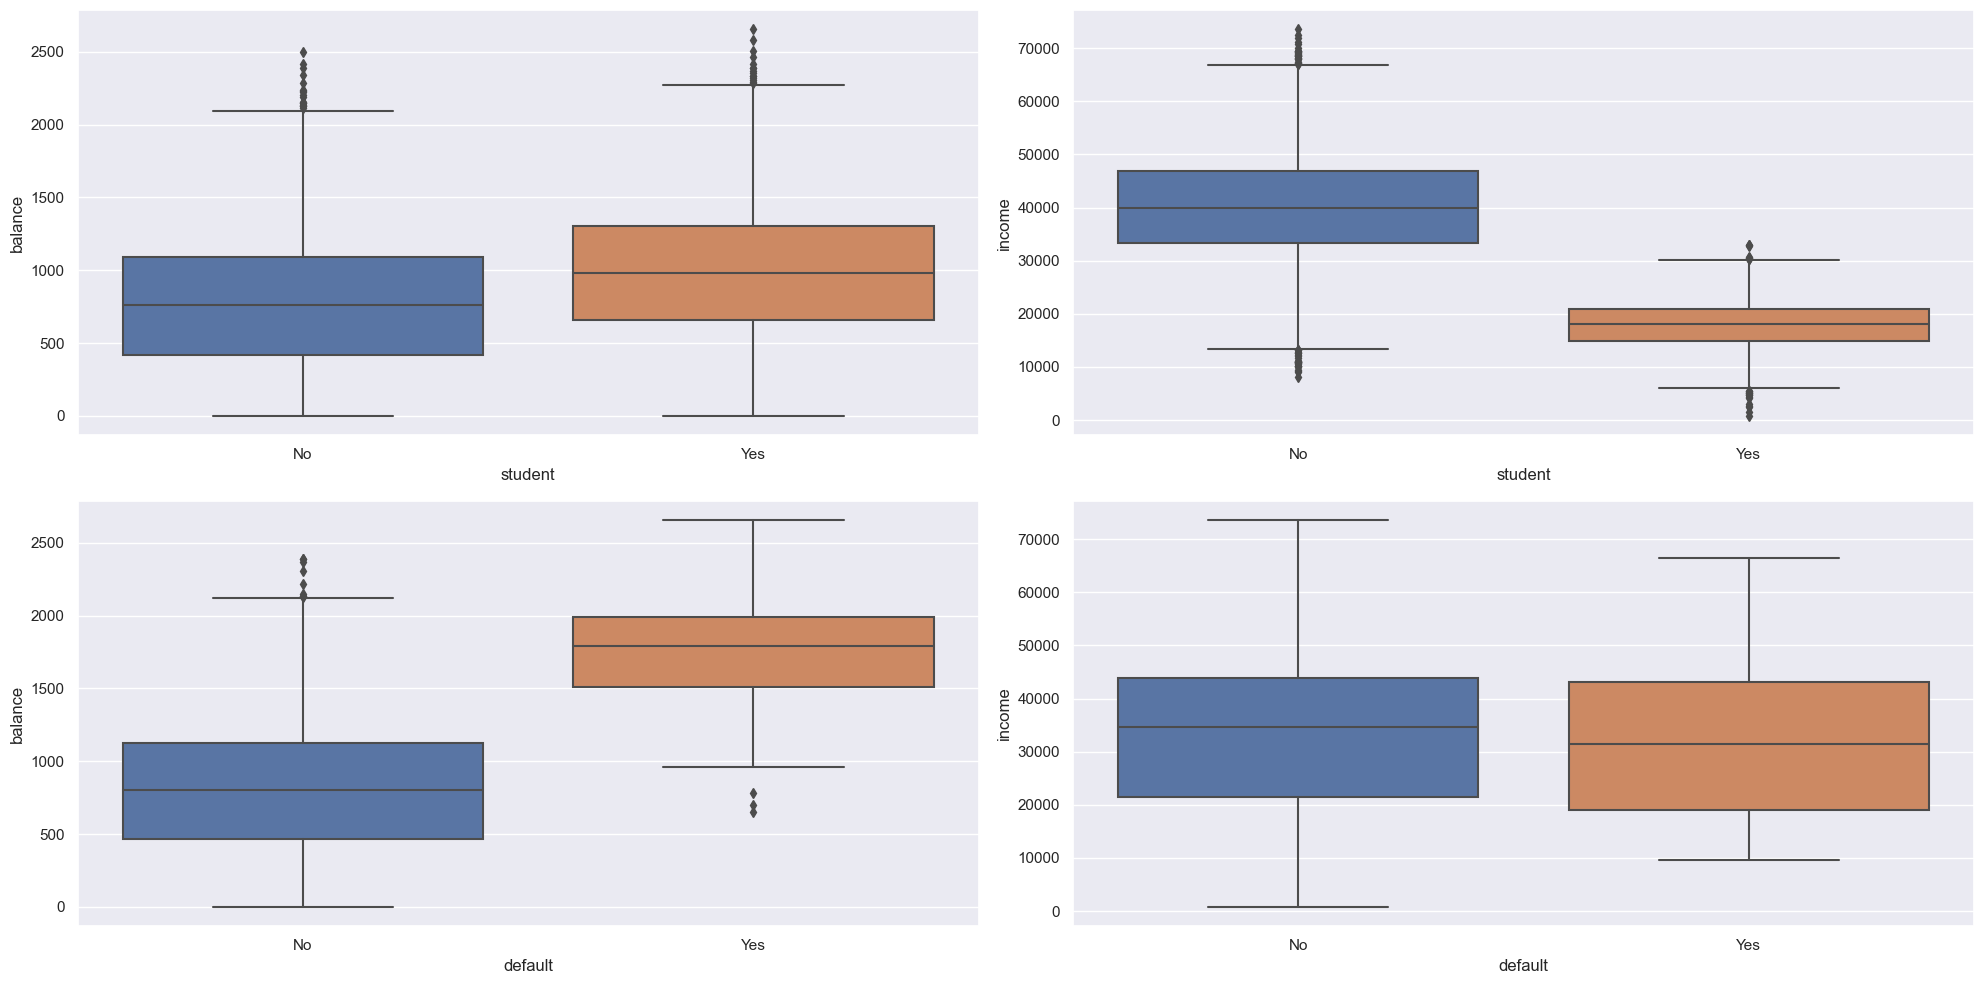

In [44]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
sns.set_theme(context='notebook')

sns.boxplot(data=df, x='student',y='balance',ax=ax[0,0]);
sns.boxplot(data=df, x='student',y='income',ax=ax[0,1]);
sns.boxplot(data=df, x='default',y='balance',ax=ax[1,0]);
sns.boxplot(data=df, x='default',y='income',ax=ax[1,1]);

plt.tight_layout()

student vs balance: the mean of students has more money in the credit account than the mean of no students. Both have several values above the standard deviation on the top.
student vs income: the students have less income in average than the no students.
default vs balance : 
default vs income : 

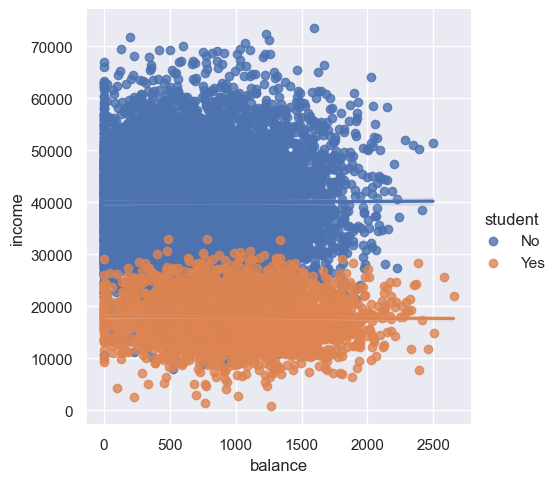

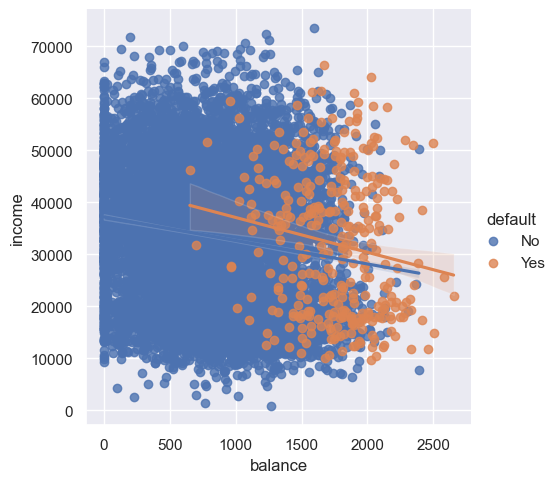

In [45]:
sns.lmplot(data=df,x ='balance', y='income',hue='student')
sns.lmplot(data=df,x ='balance', y='income',hue='default')

As you can see there is a huge disproportion between the ``yes`` and ``no`` values. These difference is well represented in the following cells.

## Encoding

In [46]:
df2 = df[:].drop('index', axis=1)

le  = LabelEncoder()
student_log = le.fit_transform(df['student'])
default_log = le.fit_transform(df['default'])
df2['student'] = student_log
df2['default'] = default_log



**Checking if are well labeled**

In [47]:
display(df['default'].value_counts(), df2['default'].value_counts())

default
No     9667
Yes     333
Name: count, dtype: int64

default
0    9667
1     333
Name: count, dtype: int64

# Depuracion

<Axes: >

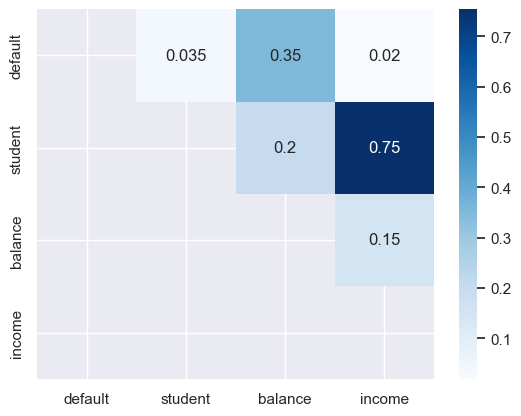

In [49]:

df2.corr().apply(np.abs)
sns.heatmap(df2.corr().abs(), cmap='Blues', annot=True, mask=np.tril(df2.corr()))


# Model 1/2: using Logistic Regression and Resampling

First is necesary to resample the data frame because to balance the number between the data with ``no`` and ``yes``. Here we will use the ``NearMiss``(undersampling) and ``RandomOverSampler`` (oversampling) ``sklearn libraries that reduce the majority data and increases the minority data, respectively. 

Model using a Logistic regression using the ``class_weight=balanced`` hyperparameter (model 1). The parameter balances the features, i.e., in our case, it reduces the number of ``no`` values to be similar to the ``yes`` ones. For the sake of this project we also create an alternative model (model 2) without ``balances`` data.

Later we will Scale the data by using ``StandardScaler`` this migth be necesary since the data set has large differences between the data.




In [ ]:
X = df2.drop('default', axis=1)
y = df2['default']

nm = NearMiss(n_neighbors=3,
                  version=1,
                  sampling_strategy=0.1)
X_res, y_res = nm.fit_resample(X,y)

display(X_res['student'].value_counts())

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_res,y_res, random_state=0, test_size=1/3)



scale = StandardScaler()

X_train_std = scale.fit_transform(X_train1)
X_test_std  = scale.transform(X_test1)

model1 = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced').fit(X_train_std,y_train1)
model2 = LogisticRegression(C=1.0, penalty='l2').fit(X_train_std,y_train1)

student
0    2305
1    1358
Name: count, dtype: int64

**Note that now the difference between ``yes``and ``no`` is around 1000.**

## Model 3: Logistic Regression with Oversampling

In [ ]:
X  = df2.drop('default', axis=1)

y  = df2['default']

ovs = RandomOverSampler(sampling_strategy='minority')

X_os , y_os  = ovs.fit_resample(X,y)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_os,y_os, random_state=0, test_size=1/3)

scale3       = StandardScaler()
X_train_std3 = scale3.fit_transform(X_train3)
X_test_std3  = scale3.transform(X_test3)

model3 = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced').fit(X_train_std3,y_train3)

**Predictions**

In [ ]:
y_pred  = model1.predict(X_test_std)
y_pred2 = model2.predict(X_test_std)
y_pred3 = model3.predict(X_test_std3)

## Metrics

**score of the model**

In [ ]:
from sklearn.metrics import accuracy_score

m1_acc_score = accuracy_score(y_test1,y_pred).round(2)
m2_acc_score = accuracy_score(y_test1,y_pred2).round(2)
m3_acc_score = accuracy_score(y_test3,y_pred3).round(2)
print('accuracy score of Logistic Regression with undersampling and balancing is:', m1_acc_score)
print('accuracy score of Logistic Regression with undersampling is:              ', m2_acc_score)
print('accuracy score of Logistic Regression with oversampling and balancing is: ', m3_acc_score)

accuracy score of Logistic Regression with undersampling and balancing is: 0.79
accuracy score of Logistic Regression with undersampling is:               0.92
accuracy score of Logistic Regression with oversampling and balancing is:  0.88


The model performance is very good concening that the score is 0.92 but it might be too good.

**confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

m1_confm =  confusion_matrix(y_test1,y_pred)
m2_confm =  confusion_matrix(y_test1,y_pred2)
m3_confm =  confusion_matrix(y_test3,y_pred3)

print('confusion matrix for model 1\n',m1_confm,'\nconfusion matrix for model 2\n',m2_confm,'\nconfusion matrix for model 3\n',m3_confm)

confusion matrix for model 1
 [[879 228]
 [ 23  91]] 
confusion matrix for model 2
 [[1095   12]
 [  86   28]] 
confusion matrix for model 3
 [[2777  441]
 [ 344 2883]]


**Precision & Sensitivity**

In [ ]:
from sklearn.metrics import precision_score, recall_score

skprec = precision_score(y_test1,y_pred).round(5)

print(f'The precision of the model {skprec})' )

skrecall = recall_score(y_test1,y_pred).round(5)
print(f'The sensitivity (recall) of the model is  {skrecall})' )

The precision of the model 0.28527)
The sensitivity (recall) of the model is  0.79825)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test1,y_pred))
print(classification_report(y_test1,y_pred2))
print('model3\n',classification_report(y_test3,y_pred3))

              precision    recall  f1-score   support

           0       0.97      0.79      0.88      1107
           1       0.29      0.80      0.42       114

    accuracy                           0.79      1221
   macro avg       0.63      0.80      0.65      1221
weighted avg       0.91      0.79      0.83      1221

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1107
           1       0.70      0.25      0.36       114

    accuracy                           0.92      1221
   macro avg       0.81      0.62      0.66      1221
weighted avg       0.91      0.92      0.90      1221

model3
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      3218
           1       0.87      0.89      0.88      3227

    accuracy                           0.88      6445
   macro avg       0.88      0.88      0.88      6445
weighted avg       0.88      0.88      0.88      6445



## Roc Curve

In [ ]:
from sklearn.metrics import roc_curve
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
ypred0 = model1.predict_proba(X_test_std)[:, 1]
ypred2 = model2.predict_proba(X_test_std)[:, 1]
ypred3 = model3.predict_proba(X_test_std3)[:, 1]
# generamos los objetos de roc_cruve
fp0, tp0, td0 = roc_curve(y_test1, ypred0)
fp2, tp2, td2 = roc_curve(y_test1, ypred2)
fp3, tp3, td3 = roc_curve(y_test3, ypred3)

In [ ]:
def plotroc(fp,tp,title=''):
    plt.title('ROC {}'.format(title))
    plt.plot(fp, tp, lw=1)
    plt.plot([0, 1], ls="--", lw=1)
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
    plt.ylabel('True Positives')
    plt.xlabel('False Positives')
    return




**ROC curve for model with Logistic Regression with undersampling and balancing**

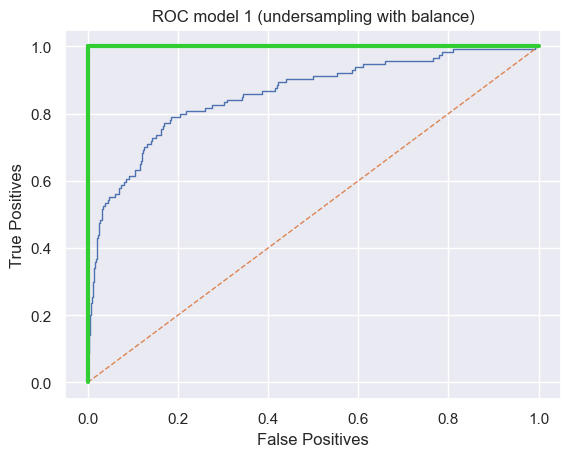

In [ ]:
plotroc(fp0,tp0,title='model 1 (undersampling with balance)')

**ROC curve for model with Logistic Regression with undersampling**

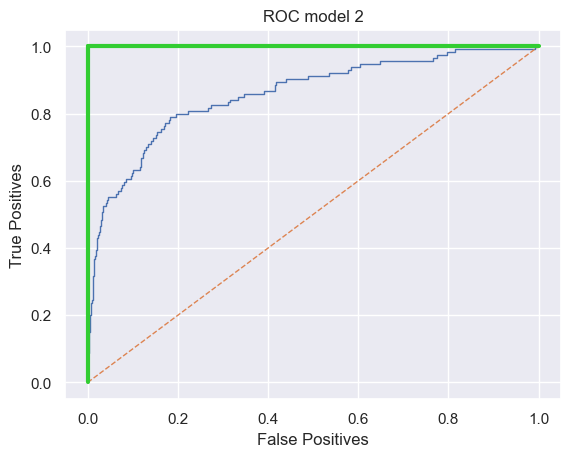

In [ ]:
plotroc(fp2,tp2, title='model 2 (undersampling no balance)')

**ROC curve for model with Logistic Regression with oversampling and balancing**

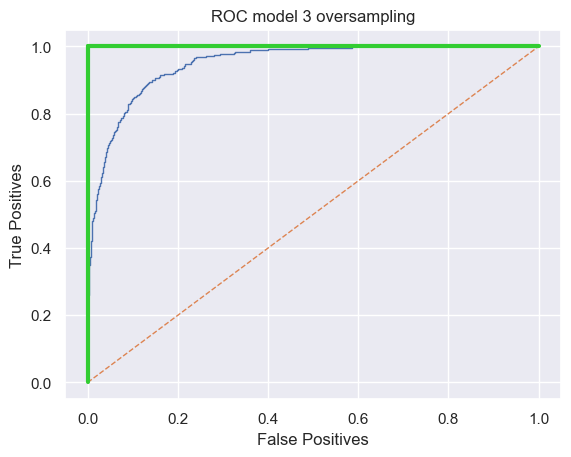

In [ ]:
plotroc(fp3,tp3, title='model 3 (oversampling)')

[url de interes](https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/)